# Tarea 3 - Análisis del Modelo de Ising


Integrantes:

- Sara Sofía Rivera Sanabria.

- Juan Sebastián Rueda Segura.

- Santiago Rocha Pachón.

Considere el modelo de Ising en un *lattice* (rejilla) $K \times K$ con $10 \le K \le 20$.  
La distribución de Gibbs está dada por:

$$
\pi_\beta(\eta) = \frac{1}{Z_\beta} e^{-\beta H(\eta)}
$$

donde el Hamiltoniano (energía) es:

$$
H(\eta) = - \sum_{x \sim y} \eta_x \eta_y
$$

y $\beta \ge 0$ es el inverso de la temperatura.



## 1. Muestreo MCMC

Use un algoritmo MCMC (como Gibbs sampler o Metropolis–Hastings) para generar 100 muestras *aproximadas* del modelo de Ising.  

Las muestras deben ser los estados de la cadena en tiempos largos (ej., $(X_{10^3}), (X_{10^4}), (X_{10^5})$) para asegurar la convergencia a la distribución estacionaria.  

Realice esto para un rango de temperaturas inversas:

$$
\beta = \{0, 0.1, 0.2, 0.3, \ldots, 0.9, 1.0\}
$$


Pequeña interpretación: Imaginemos una red cuadrada donde en cada posición hay un pequeño imán que puede apuntar hacia arriba o hacia abajo. Estos imanes interactúan con sus vecinos inmediatos: prefieren alinearse en la misma dirección porque eso minimiza la energía del sistema. Sin embargo, la temperatura introduce aleatoriedad que puede desalinear los spins. A temperaturas bajas, los spins tienden a ordenarse todos en la misma dirección, pero a temperaturas altas, el desorden térmico domina y los spins apuntan aleatoriamente.

Numba es una biblioteca especial que compila funciones de Python a código máquina ultrarrápido, lo cual es esencial porque vamos a hacer millones de operaciones.

In [1]:
pip install numba tqdm matplotlib

Note: you may need to restart the kernel to use updated packages.


In [1]:
import random

import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from tqdm import tqdm

La función recibe tres parámetros fundamentales: spin es la matriz que contiene nuestra rejilla de spins o sea los valores +1 o -1, L determina el tamaño de la rejilla L×L, y beta es la temperatura inversa.

Un barrido significa intentar voltear cada spin en promedio una vez. En cada iteración, seleccionamos aleatoriamente una posición (x, y) en la rejilla y guardamos el valor del spin en esa posición.

Luego calculamos la suma de los cuatro vecinos más cercanos del spin seleccionado. Esta suma R puede tomar valores entre -4 (todos los vecinos apuntan en dirección opuesta) y +4 (todos los vecinos apuntan en la misma dirección).

dH calcula el cambio de energía si volteamos el spin. Si R = 4 y el hamiltoneano es -1×4 = -4. Si volteamos el spin a -1, la nueva energía sería +1×4 = +4. El cambio es ΔH = 4 - (-4) = 8. La fórmula 2×s×R captura este cambio: 2×(+1)×4 = 8. El factor 2 aparece porque al voltear el spin de +s a -s, el cambio es 2s veces la suma de vecinos.

AHORA SI, el criterio de Metropolis-Hastings. Si voltear el spin disminuye la energía (dH < 0), siempre aceptamos el cambio porque el sistema naturalmente prefiere estados de menor energía. Si voltear el spin aumenta la energía (dH > 0), no rechazamos el cambio automáticamente. En su lugar, lo aceptamos con probabilidad $e^{-β ΔH}$. A temperaturas altas (β pequeño), esta probabilidad es grande y aceptamos muchos cambios desfavorables, ES DECIR, DESORDEN. A temperaturas bajas (β grande), la probabilidad es pequeña y raramente aceptamos cambios que aumentan la energía.

In [2]:
@numba.jit(nopython=True)
def _metropolis(spin, L, beta):
    """
    Realiza un barrido completo de metropolis-hastings sobre la rejilla.
    El spin será modificado al pasarlo por referencia.
    """
    for _ in range(L ** 2):
        x, y = random.randint(0, L - 1), random.randint(0, L - 1) #Obtener coordenadas
        s = spin[x, y]

        # Vecinos con condiciones periódicas,
        #la idea es que nuestra red no tiene bordes reales: si nos movemos más allá del borde derecho, aparecemos en el borde izquierdo, como en pac-man.
        # Esto elimina efectos de borde no deseados.
        xpp = (x + 1) if (x + 1) < L else 0 #pp es plus plus
        ypp = (y + 1) if (y + 1) < L else 0
        xnn = (x - 1) if (x - 1) >= 0 else (L - 1)
        ynn = (y - 1) if (y - 1) >= 0 else (L - 1)

        R = spin[xpp, y] + spin[x, ypp] + spin[xnn, y] + spin[x, ynn]
        dH = 2 * s * R

        if dH < 0:
            s = -s
        elif beta > 0 and np.random.rand() < np.exp(-beta * dH):
            s = -s

        spin[x, y] = s

Esta función calcula la energía total del sistema. Recorremos cada spin y sumamos su interacción con sus vecinos de derecha y abajo (de modo que se cuente cada arista una única vez, es decir, al ser un grafo no-dirigido, $(x, y) = (y, x)$ en $E$). La energía se divide por L² para obtener la energía promedio por spin.

In [3]:
@numba.jit(nopython=True)
def calc_energy(spin, L):
    """Calcula la energía promedio por spin"""
    energy = 0.0
    for i in range(L):
        for j in range(L):
            s = spin[i, j]
            right = spin[(i + 1) % L, j]
            down = spin[i, (j + 1) % L]
            energy += -s * (right + down)
    return energy / (L * L)

La magnetización es simplemente la suma de todos los spins dividida por el número total de spins. Si todos los spins apuntan hacia arriba (+1), la magnetización es +1. Si todos apuntan hacia abajo (-1), la magnetización es -1. Si hay igual cantidad de spins arriba y abajo, la magnetización es cero. Dividimos por L² para obtener la magnetización promedio por spin.

In [4]:
@numba.jit(nopython=True)
def calc_magnetization(spin, L):
    """Calcula la magnetización promedio por spin"""
    return np.sum(spin) / (L * L)

A continuación, un ejemplo del uso de las dos funciones.

In [5]:
spin = np.array([[1, 1, 1],
                [1, 1, 1],
                [1, 1, 1]])
L = 3
print(calc_energy(spin, L))
print(calc_magnetization(spin, L))

-2.0
1.0


Esta función genera una muestra del modelo de Ising corriendo una cadena de Markov por muchos pasos. La función np.random.randint(2, size=(K, K)) genera una matriz K×K de ceros y unos aleatorios. Al multiplicar por 2 obtenemos ceros y doses, y al restar 1 obtenemos -1 y +1, que son exactamente los valores que necesitamos para los spins.

Comenzamos con una configuración aleatoria. Luego aplicamos Metropolis-Hastings repetidamente. Cada aplicación realiza un barrido completo de la rejilla. Tras muchos barridos, el sistema "olvida" su configuración inicial y alcanza el equilibrio térmico a la temperatura especificada.


In [5]:
import os

from numba.typed import List
from numba import types, float64

def get_samples_mcmc(dimension: int, beta: float, mcmc_steps: int = 10000, m_and_e_calc: bool = True, file_path: str = None, n_samples: int = 100):
    """
    Computes `n_samples` samples of the Ising model with a
    `dimension` x `dimension` lattice and `beta` using the
    Metropolis-Hastings algorithm. It optionally stores the results
    in a csv with `file_path` name inside the folder `H3/results/`.

    Also, it will return the energy and magnetization of every
    configuration alongisde it if `m_and_e_calc` is True.

    Parameters
    ----------
    - dimension: int
        The square of the size of the lattice, i.e., it will have 
        `dimension` x `dimension` particles
    - beta: float
        The inverse of the temperature to compute the samples with.
    - m_and_e_calc: bool, optional
        If True, calculate the energy and magnetization of each
        configuration. Deafults to True
    - file_path: str, optional
        If provided, the results will be stored at
        `H3/results/file_path`. Defaults to None (don't save it)
    - n_samples: int
        Number of samples to compute. Defaults to 100

    Returns
    -------
    samples: pd.DataFrame
        A DataFrame containing at least a column of all the samples'
        configurations and if `m_and_e_calc` is set to True, two
        additional columns containing the energy and magnetization
        of each configuration.
    """

    # triplet_type = types.Tuple((types.Array(float64, 2, "A"), float64, float64))
    data_list = []
    with tqdm(total=n_samples, desc="Generando muestras usando Metropolis-Hastings") as pbar:
        for _ in range(n_samples):
            config = 2 * np.random.randint(2, size=(dimension, dimension)) - 1
            for _ in range(mcmc_steps):
                _metropolis(config, dimension, beta)
            pbar.update(1)
            
            if m_and_e_calc:
                data_list.append((config, calc_energy(config, dimension), calc_magnetization(config, dimension)))
            else:
                data_list.append(config)

    columns: list[str] = ['config', 'energy', 'magnetization'] if m_and_e_calc else ['config']
    data_df: pd.DataFrame = pd.DataFrame(data_list, columns = columns)
    if file_path is not None:
        os.makedirs("H3/results", exist_ok=True)
        data_df.to_csv(f"H3/results/{file_path}")
        
    return data_df

In [7]:
get_samples_mcmc(dimension=10, beta=0.4, mcmc_steps=10000, n_samples = 100)

Generando muestras usando Metropolis-Hastings: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


,config,energy,magnetization
0,"[[-1, 1, -1, -1, -1, -1, -1, -1, -1, -1], [1, ...",-1.12,-0.68
1,"[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, ...",-1.40,0.82
2,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1...",-1.24,-0.34
3,"[[1, 1, 1, -1, -1, -1, 1, 1, 1, 1], [1, -1, -1...",-1.36,-0.54
4,"[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1], [-1...",-1.36,-0.74
...,...,...,...
95,"[[1, 1, 1, -1, -1, -1, -1, -1, -1, 1], [1, 1, ...",-0.84,-0.12
96,"[[1, -1, -1, -1, -1, -1, 1, 1, 1, 1], [1, -1, ...",-1.12,-0.18
97,"[[1, 1, 1, -1, 1, 1, 1, 1, 1, -1], [1, 1, 1, 1...",-1.52,0.84
98,"[[-1, -1, -1, -1, 1, 1, -1, 1, -1, -1], [1, -1...",-0.96,0.34


Experimento con tamaños de red de 10 hasta 20, y temperaturas inversas de 0.0 a 1.0 en incrementos de 0.1. Este doble bucle anidado genera las 121 muestras (11 valores de K × 11 valores de β). Para cada combinación, generamos una muestra corriendo la cadena MCMC. Guardamos la magnetización en valor absoluto porque en el modelo de Ising hay una simetría: estados con todos los spins arriba y todos los spins abajo tienen la misma energía, así que el sistema puede estar en cualquiera de los dos estados ordenados.

In [6]:

def run_ising_experiment(K_range=(10, 21),
                        betas=None,
                        mcmc_steps=10000,
                        seed=42):
    """
    Ejecuta el experimento: UNA muestra por cada par (K, β).

    """
    if betas is None:
        betas = [round(i * 0.1, 1) for i in range(11)]  # 0.0, 0.1, ..., 1.0

    np.random.seed(seed)
    random.seed(seed)

    K_values = list(range(K_range[0], K_range[1]))

    print("="*70)
    print("EXPERIMENTO: MODELO DE ISING CON MCMC")
    print("="*70)
    print(f"Tamaños de red (K): {K_values[0]} a {K_values[-1]} → {len(K_values)} tamaños")
    print(f"Temperaturas inversas (β): {len(betas)} valores")
    print(f"Pasos MCMC por muestra: {mcmc_steps}")
    print(f"Total de muestras: {len(K_values)} × {len(betas)} = {len(K_values) * len(betas)}")
    print("="*70 + "\n")

    # Estructura de resultados sera dicc anidado
    results = {
        'K_values': K_values,
        'betas': betas,
        'energies': {},      # results['energies'][K][beta] = valor unico
        'magnetizations': {},  # magnetizations[K][beta] = valor unico
        'samples': {}        # samples[K][beta] = configuración única
    }

    for K in K_values: #inicializar vacios
        results['energies'][K] = {}
        results['magnetizations'][K] = {}
        results['samples'][K] = {}

    # Generar UNA muestra por cada (K, β)
    total_iterations = len(K_values) * len(betas)

    with tqdm(total=total_iterations, desc="Generando muestras") as pbar:
        for K in K_values:
            for beta in betas:
                # Correr cadena MCMC
                data_df = get_samples_mcmc(K, beta, mcmc_steps, n_samples=1)

                results['samples'][K][beta] = data_df.loc[0, 'config']
                results['energies'][K][beta] = data_df.loc[0, 'energy']
                results['magnetizations'][K][beta] = abs(data_df.loc[0, 'magnetization'])

                pbar.update(1)

    return results

In [84]:
results = run_ising_experiment(
    K_range=(10, 15),
    betas=None,
    mcmc_steps=10000,
    seed=42
)

EXPERIMENTO: MODELO DE ISING CON MCMC
Tamaños de red (K): 10 a 14 → 5 tamaños
Temperaturas inversas (β): 11 valores
Pasos MCMC por muestra: 10000
Total de muestras: 5 × 11 = 55



Generando muestras: 100%|██████████| 55/55 [00:04<00:00, 13.21it/s]


Esta función crea dos figuras principales con valores extraidos de K y β de los resultados.

In [ ]:
def visualize_results(results):

    K_values = results['K_values']
    betas = results['betas']

    #  FIGURA 1: REJILLAS
    print("Configuraciones")
    print("-"*70)

    # Seleccionar 3 valores espaciados, el mas pequeño, el intermedio y el mas grande, PODRIAN SER MAS?
    K_indices = [0, len(K_values)//2, -1]
    K_selected = [K_values[i] for i in K_indices]

    # Seleccionar betas representativos (5 valores?)
    beta_indices = [0, len(betas)//4, len(betas)//2, 3*len(betas)//4, -1]
    betas_selected = [betas[i] for i in beta_indices]

    fig, axes = plt.subplots(len(K_selected), len(betas_selected),
                            figsize=(15, 9))

    for i, K in enumerate(K_selected):
        for j, beta in enumerate(betas_selected):
            sample = results['samples'][K][beta]

            axes[i, j].imshow(sample, cmap='RdBu', vmin=-1, vmax=1, interpolation='nearest') #ROJO+1 AZUL-1
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])

            if i == 0:
                temp_str = f"β = {beta:.1f}"
                axes[i, j].set_title(temp_str, fontsize=12, fontweight='bold')

            if j == 0:
                axes[i, j].set_ylabel(f'K = {K}', fontsize=12, fontweight='bold', rotation=0, labelpad=30)

    plt.suptitle('Configuraciones del Modelo de Ising\n(Rojo: +1, Azul: -1)',
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

    # FIGURA 2: PROPIEDADES TERMODINÁMICAS
    print("\n Propiedades Termodinámicas")
    print("-"*70)

    # Preparar datos para mejor graficacion
    avg_energies = {}
    avg_mags = {}

    for K in K_values: #creamos listas que contienen la energía y magnetización para todos los valores de β
        avg_energies[K] = [results['energies'][K][beta] for beta in betas]
        avg_mags[K] = [results['magnetizations'][K][beta] for beta in betas]

    # convertir beta a temperatura T=1/beta
    temperatures = [1/b if b > 0 else 10 for b in betas]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    colors = plt.cm.viridis(np.linspace(0, 1, len(K_values)))

    # Magnetizacion vs beta
    ax = axes[0]
    for idx, K in enumerate(K_values):
        ax.plot(betas, avg_mags[K], 'o-', color=colors[idx],
                label=f'K={K}', markersize=5, linewidth=1.5, alpha=0.8)
    #TODO: Consider changing to latex format
    ax.set_xlabel('Temperatura inversa (β)', fontsize=12, fontweight='bold')
    ax.set_ylabel('|Magnetización|', fontsize=12, fontweight='bold')
    ax.set_title('Magnetización vs β', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)

    # Energia vs T
    ax = axes[1]
    for idx, K in enumerate(K_values):
        ax.plot(temperatures[1:], avg_energies[K][1:], 'o-', color=colors[idx],
                label=f'K={K}', markersize=5, linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Temperatura (T = 1/β)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Energía por spin', fontsize=12, fontweight='bold')
    ax.set_title('Energía vs Temperatura', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=8, ncol=2)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0, 10])


    plt.tight_layout()
    plt.show()

EXPERIMENTO: MODELO DE ISING CON MCMC
Tamaños de red (K): 10 a 20 → 11 tamaños
Temperaturas inversas (β): 11 valores
Pasos MCMC por muestra: 10000
Total de muestras: 11 × 11 = 121



Generando muestras: 100%|██████████| 121/121 [00:17<00:00,  6.81it/s]


Configuraciones
----------------------------------------------------------------------


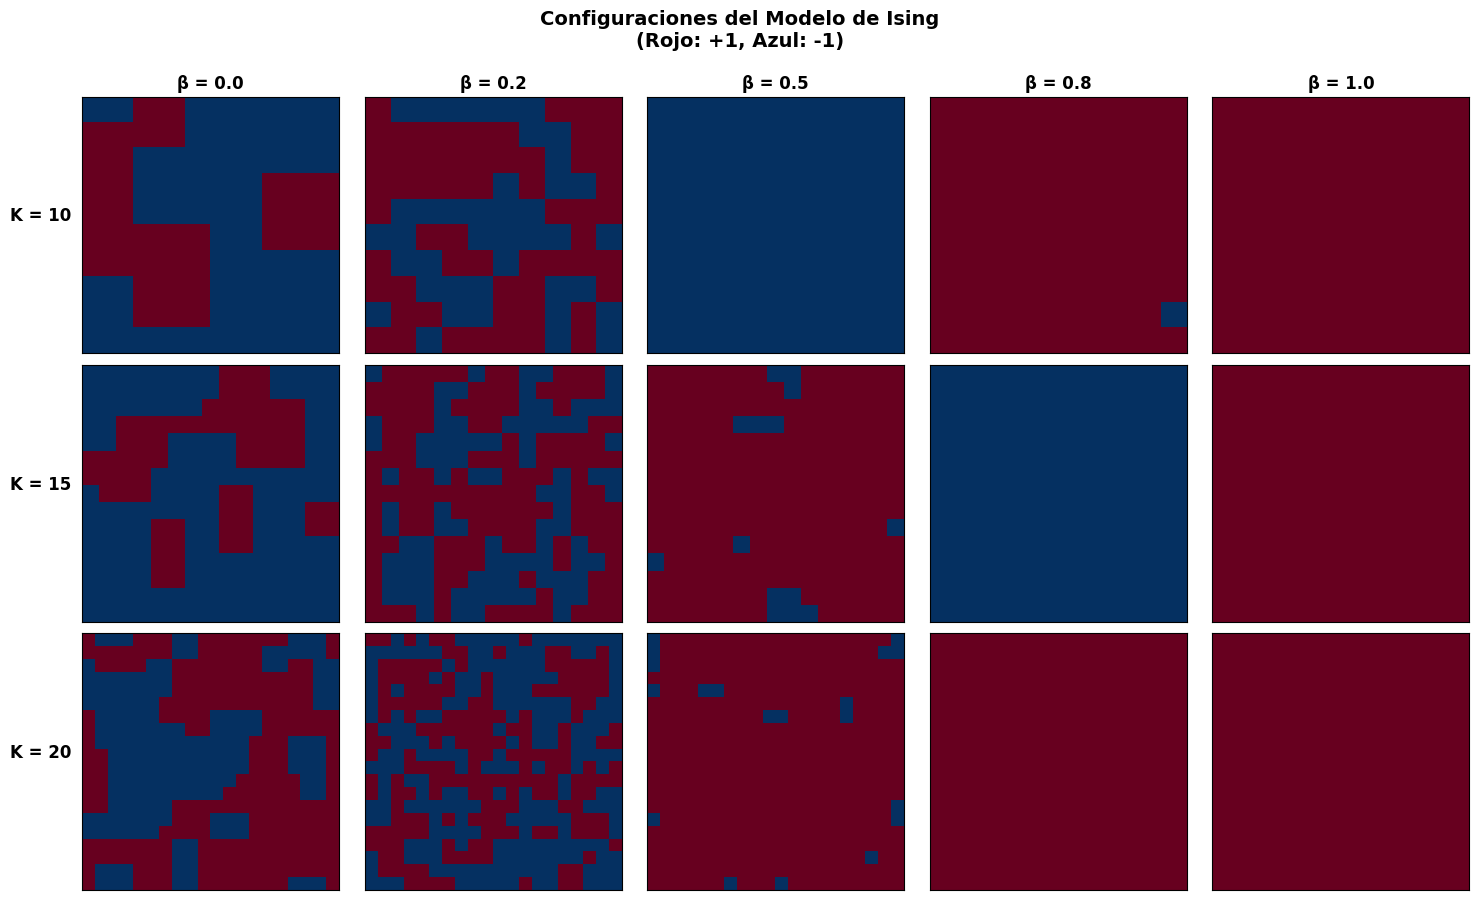


 Propiedades Termodinámicas
----------------------------------------------------------------------


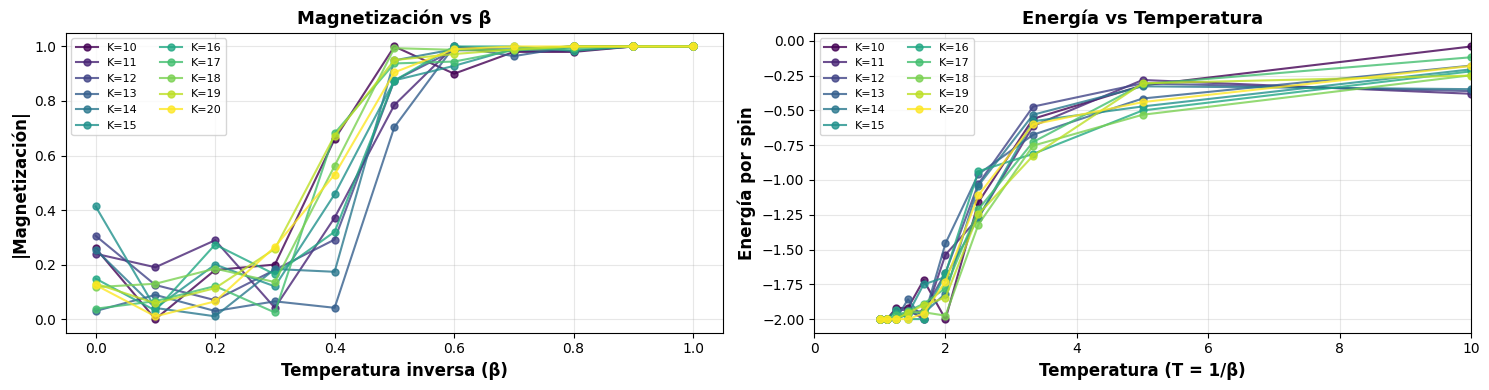

In [91]:
if __name__ == "__main__":
    results = run_ising_experiment(
        K_range=(10, 21),
        betas=[i * 0.1 for i in range(11)],
        mcmc_steps=10000,
        seed=42
    )


    visualize_results(results)

## 2. Muestreo Perfecto, Algoritmo Propp-Wilson

En el punto pasado utilizamos el Metrópolis-Hastings para generar muestras, pero en este caso debemos utilizar el Gibbs Sampler puesto que fue el que se comentó en clase al demostrarse que era monótono con la relación de orden que definiremos pronto. 

Recordemos la idea del Sandwiching: Si podemos introducir un orden parcial en el conjunto de estados $S$ y ese orden es respetado por la dinámica de la cadena, si corremos las cadenas que empiezan con las configuraciones maximal y minimal, garantizaramos la coalescencia de todos los estados posibles al estar siempre en medio de estos dos estados. Definamos pues el orden parcial entre los estados:

Dado $G = (V,E)$, sea $x' \in V$. Definimos la relación de orden entre los estados, dependiendo de $x'$ como:

$$
\xi \leq_{x'} \eta \iff \xi_x \leq \eta_x \forall x \neq x'
$$

Donde $\xi, \eta \in \{-1,1\}^V$ y $\xi_x \leq \eta_x \forall x \neq x'$ significa que los todas las entradas de la configuración $\xi$, exceptuando $x$, son menores que todas las correspondientes entradas de $\eta$.

Una vez definido el orden, creemos las clases auxiliares para poder comparar configuraciones y aplicar el muestreador de Gibbs rápidamente:


In [6]:
import numpy as np
import random

numba_spec = [
    ('beta', numba.float64),
    ('dimension', numba.int64),
    ('matrix', numba.float64[:, :]),
]

@numba.experimental.jitclass(numba_spec)
class Configuration:
    def __init__(self, beta, dimension):
        self.beta = beta
        self.dimension = dimension
        self.matrix = np.empty((dimension, dimension))
        for idx in np.ndindex((dimension, dimension)):
            self.matrix[idx] = 1.0 if np.random.rand() < 0.5 else -1.0

    def set_maximal(self):
        for i in range(self.dimension):
            for j in range(self.dimension):
                self.matrix[i, j] = 1

    def set_minimal(self):
        for i in range(self.dimension):
            for j in range(self.dimension):
                self.matrix[i, j] = -1
        
    def k_plus(self, x, y):
        num = 0
        xpp = (x + 1) if (x + 1) < self.dimension else 0 #*right
        ypp = (y + 1) if (y + 1) < self.dimension else 0 #*down
        xnn = (x - 1) if (x - 1) >= 0 else (self.dimension - 1) #*left
        ynn = (y - 1) if (y - 1) >= 0 else (self.dimension - 1) #*up
        
        if self.matrix[xpp, y] == 1:
            num += 1
        if self.matrix[x, ypp] == 1:
            num += 1
        if self.matrix[xnn, y] == 1:
            num += 1
        if self.matrix[x, ynn] == 1:
            num += 1
        return num
    
    def k_minus(self, x, y):
        num = 0
        xpp = (x + 1) if (x + 1) < self.dimension else 0 #*right
        ypp = (y + 1) if (y + 1) < self.dimension else 0 #*down
        xnn = (x - 1) if (x - 1) >= 0 else (self.dimension - 1) #*left
        ynn = (y - 1) if (y - 1) >= 0 else (self.dimension - 1) #*up
        
        if self.matrix[xpp, y] == -1:
            num += 1
        if self.matrix[x, ypp] == -1:
            num += 1
        if self.matrix[xnn, y] == -1:
            num += 1
        if self.matrix[x, ynn] == -1:
            num += 1
        return num

    def gibbs_sampler_step_from(self, N, random_list):
        x,y = random_list.V_list[N]
        k_plus = self.k_plus(x, y)
        k_minus = self.k_minus(x, y)
        
        self.matrix[x, y] = 1 if random_list.U_list[N] < (np.exp(2*self.beta*(k_plus - k_minus)))/(np.exp(2*self.beta*(k_plus - k_minus)) + 1) else -1

        return x, y, self.matrix[x, y]
 
    def __eq__(self, other: "Configuration"):
        return np.array_equal(self.matrix, other.matrix)
    
    # Método para comparar dos configuraciones excluyendo la posición x
    def is_leq_x(self, other: "Configuration", x: tuple) -> bool:
        for i in range(self.dimension):
            for j in range(self.dimension):
                if x[0] == i and x[1] == j:
                    continue
                if self.matrix[i, j] > other.matrix[i, j]:
                    return False
        return True
    

De acá cabe resaltar que para el Sampler estamos usando una lista de U_i's y de Vértices escogidos uniformemente del intervalo (0,1) y de los vértices de la matriz respectivamente. Crearemos una clase de lista aleatoria, ya que para cada paso vamos a necesitar guardar los U_i y V_i y a su vez generar 2^N_i - 2^N_{i-1} nuevos. Esto para poder aplicar los mismos números aleatorios sobre los mismos vértices en las cadenas de Markov. Una vez tenemos la estructura general de una configuración, heredamos de esta clase para construir las configuraciones minimales y maximales:

In [7]:
import numpy as np
from numba import njit, int64, float64, types
from numba.experimental import jitclass
from numba.typed import List


#*For compatibility with Numba, U_list and V_list must be defined as
#*Numba types
pair_type = types.UniTuple(int64, 2)

random_lists_spec = [
    ('U_list', types.ListType(float64)),
    ('V_list', types.ListType(pair_type)),
]

@jitclass(random_lists_spec)
class RandomLists:
    def __init__(self):
        self.U_list = List.empty_list(float64)
        self.V_list = List.empty_list(pair_type)

    def extend(self, n_new, dimension):
        for _ in range(n_new):
            u = np.random.rand()
            x = np.random.randint(0, dimension)
            y = np.random.randint(0, dimension)
            self.U_list.append(u)
            self.V_list.append((x, y))


Ahora ya estamos en condiciones para correr el algoritmo Propp-Wilson y aplicar Sandwiching:

In [8]:
@numba.jit(nopython=True)
def propp_wilson_sandwiching(beta, dimension):
    N_j_minus_1 = 0
    N_j = 1
    random_list = RandomLists()
    max_config: Configuration = Configuration(beta, dimension)
    max_config.set_maximal()
    min_config: Configuration = Configuration(beta, dimension)
    min_config.set_minimal()

    #Vamos a correr hasta hallar el N_j tal que ambas cadenas X^{top}_{-N_j} y X^{bottom}_{-N_j} coalescan
    while True:
        random_list.extend(N_j - N_j_minus_1, dimension) # Añadimos los nuevos U_i y V_i necesarios para N_j - N_j_minus_1 iteraciones del sampler
        for i in range(N_j - 1, 0, -1):
            max_config.gibbs_sampler_step_from(i, random_list)
            min_config.gibbs_sampler_step_from(i, random_list)
            
        if max_config == min_config:
            return N_j - i + 1, max_config.matrix # Ambas cadenas coalescieron en esta configuración


        #En N_j - N_j_minus_1 iteraciones no coalescieron, duplicamos N_j 
        N_j_minus_1 = N_j
        N_j *= 2
        max_config = Configuration(beta, dimension)
        max_config.set_maximal()
        min_config = Configuration(beta, dimension)
        min_config.set_minimal()
        
# propp_wilson_sandwiching(beta=0.4, dimension=10)
    

Una vez con este código, podemos obtener las muestras requeridas para varios tamaños de rejillas

In [9]:
import os

def get_samples_pw(beta: float, dimension: int, m_and_e_calc: bool = True, file_path: str = None, n_samples: int = 100):
    """
    Computes `n_samples` samples of the Ising model with a
    `dimension` x `dimension` lattice and `beta` using the Propp-Wilson
    algorithm (perfect simulation). It optionally stores the results in
    a csv with `file_path` name inside the folder `H3/results/`.

    Also, it will return the energy and magnetization of every
    configuration alongisde it if `m_and_e_calc` is True.

    Parameters
    ----------
    - beta: float
        The inverse of the temperature to compute the samples with.
    - dimension: int
        The square of the size of the lattice, i.e., it will have 
        `dimension` x `dimension` particles
    - m_and_e_calc: bool, optional
        If True, calculate the energy and magnetization of each
        configuration. Deafults to True
    - file_path: str, optional
        If provided, the results will be stored at
        `H3/results/file_path`. Defaults to None (don't save it)
    - n_samples: int
        Number of samples to compute. Defaults to 100

    Returns
    -------
    samples: pd.DataFrame
        A DataFrame containing at least a column of all the samples'
        configurations and if `m_and_e_calc` is set to True, two
        additional columns containing the energy and magnetization
        of each configuration.
    """
    # float_matrix = types.Array(float64, 2, "A")
    # triplet_type = types.Tuple(float_matrix, float64, float64)
    data_list = []
    # with tqdm(total=n_samples, desc="Generando muestras usando Propp-Wilson") as pbar:
    for i in range(n_samples):
        N, config = propp_wilson_sandwiching(beta, dimension)
        if m_and_e_calc:
            data_list.append([config, calc_energy(config, dimension), calc_magnetization(config, dimension), N])
        else:
            data_list.append(config)
        # pbar.update(1)
        print(f"\rGenerando muestras: {i+1}/{n_samples}")

    columns: list[str] = ['config', 'energy', 'magnetization', 'coupling_time'] if m_and_e_calc else ['config']
    data_df: pd.DataFrame = pd.DataFrame(data_list, columns = columns)
    if file_path is not None:
        os.makedirs("H3/results", exist_ok=True)
        data_df.to_csv(f"H3/results/{file_path}")
        
    return data_df

In [39]:
get_samples_pw(beta=0.4, dimension=10, n_samples=1)

Generando muestras: 1/1


,config,energy,magnetization,coupling_time
0,"[[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1...",-1.4,-0.72,65536


Generando muestras: 1/100
Generando muestras: 2/100
Generando muestras: 3/100
Generando muestras: 4/100
Generando muestras: 5/100
Generando muestras: 6/100
Generando muestras: 7/100
Generando muestras: 8/100
Generando muestras: 9/100
Generando muestras: 10/100
Generando muestras: 11/100
Generando muestras: 12/100
Generando muestras: 13/100
Generando muestras: 14/100
Generando muestras: 15/100
Generando muestras: 16/100
Generando muestras: 17/100
Generando muestras: 18/100
Generando muestras: 19/100
Generando muestras: 20/100
Generando muestras: 21/100
Generando muestras: 22/100
Generando muestras: 23/100
Generando muestras: 24/100
Generando muestras: 25/100
Generando muestras: 26/100
Generando muestras: 27/100
Generando muestras: 28/100
Generando muestras: 29/100
Generando muestras: 30/100
Generando muestras: 31/100
Generando muestras: 32/100
Generando muestras: 33/100
Generando muestras: 34/100
Generando muestras: 35/100
Generando muestras: 36/100
Generando muestras: 37/100
Generando 

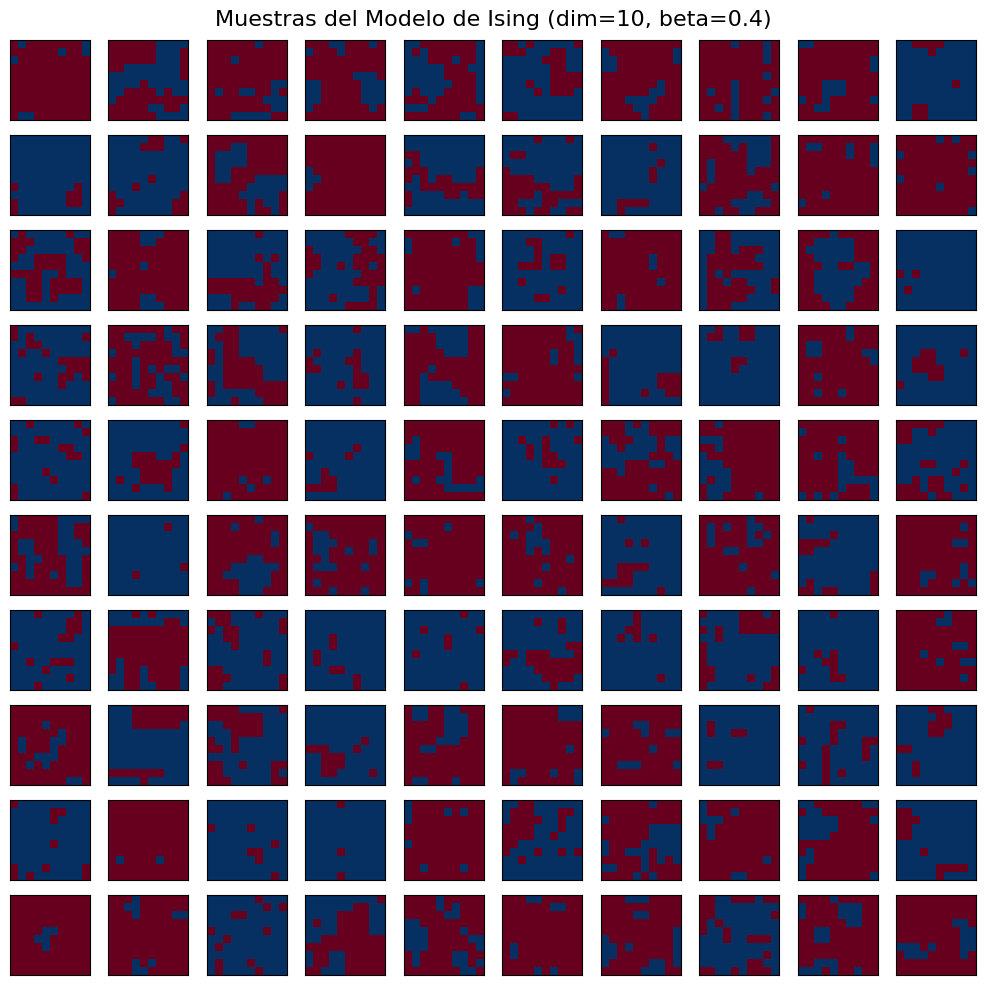

Generando muestras: 1/100
Generando muestras: 2/100
Generando muestras: 3/100
Generando muestras: 4/100
Generando muestras: 5/100
Generando muestras: 6/100
Generando muestras: 7/100
Generando muestras: 8/100
Generando muestras: 9/100
Generando muestras: 10/100
Generando muestras: 11/100
Generando muestras: 12/100
Generando muestras: 13/100
Generando muestras: 14/100
Generando muestras: 15/100
Generando muestras: 16/100
Generando muestras: 17/100
Generando muestras: 18/100
Generando muestras: 19/100
Generando muestras: 20/100
Generando muestras: 21/100
Generando muestras: 22/100
Generando muestras: 23/100
Generando muestras: 24/100
Generando muestras: 25/100
Generando muestras: 26/100
Generando muestras: 27/100
Generando muestras: 28/100
Generando muestras: 29/100
Generando muestras: 30/100
Generando muestras: 31/100
Generando muestras: 32/100
Generando muestras: 33/100
Generando muestras: 34/100
Generando muestras: 35/100
Generando muestras: 36/100
Generando muestras: 37/100
Generando 

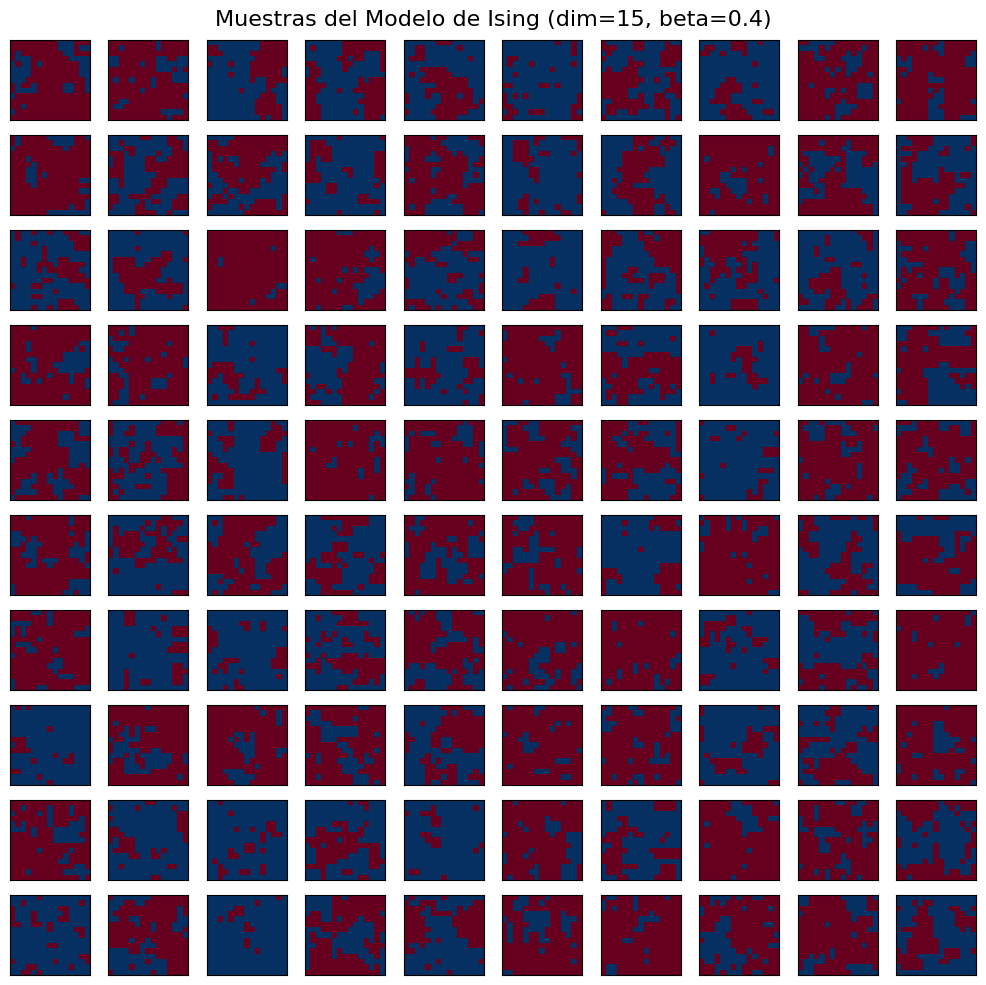

Generando muestras: 1/100
Generando muestras: 2/100
Generando muestras: 3/100
Generando muestras: 4/100
Generando muestras: 5/100
Generando muestras: 6/100
Generando muestras: 7/100
Generando muestras: 8/100
Generando muestras: 9/100
Generando muestras: 10/100
Generando muestras: 11/100
Generando muestras: 12/100
Generando muestras: 13/100
Generando muestras: 14/100
Generando muestras: 15/100
Generando muestras: 16/100
Generando muestras: 17/100
Generando muestras: 18/100
Generando muestras: 19/100
Generando muestras: 20/100
Generando muestras: 21/100
Generando muestras: 22/100
Generando muestras: 23/100
Generando muestras: 24/100
Generando muestras: 25/100
Generando muestras: 26/100
Generando muestras: 27/100
Generando muestras: 28/100
Generando muestras: 29/100
Generando muestras: 30/100
Generando muestras: 31/100
Generando muestras: 32/100
Generando muestras: 33/100
Generando muestras: 34/100
Generando muestras: 35/100
Generando muestras: 36/100
Generando muestras: 37/100
Generando 

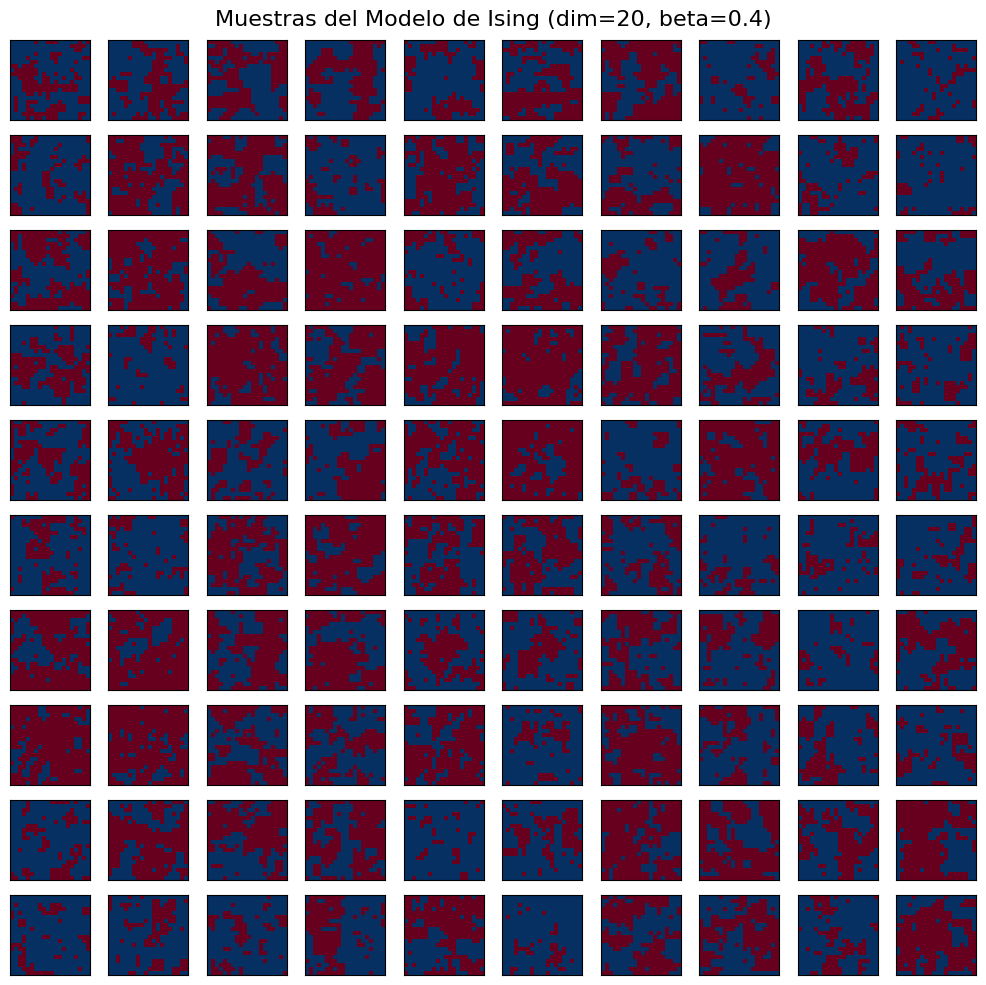

In [15]:
for dim in [10, 15, 20]:
    df = get_samples_pw(beta=0.4, dimension=dim, n_samples=100, file_path='test.csv')
    samples = df['config']
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(10):
        for j in range(10):
            axes[i, j].imshow(samples.iloc[i*10 + j], cmap='RdBu', vmin=-1, vmax=1, interpolation='nearest')
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
    plt.suptitle(f'Muestras del Modelo de Ising (dim={dim}, beta=0.4)', fontsize=16)
    plt.tight_layout()
    plt.show()

## 3. Estimación de la magnetización

Estime el valor esperado de la magnetización, $E[M(\eta)]$, donde la magnetización de una configuración $\eta$ se define como:
$$
M(\eta) = \frac{1}{|V_K|} \sum_{x \in V_K} \eta_x
$$

(siendo $|V_K| = K^2$ el número de sitios). Realice esta estimación usando tanto las muestras aproximadas del ítem (a) como las muestras exactas del ítem (b).

El valor esperado de la magnetización es:
$$
E[M(\eta)] = \frac{1}{|V_k| \cdot Z_{G, \beta}} \cdot \sum_{\eta \in \{-1, +1\}^V} e^{-\beta H(\eta)} \cdot \sum_{x \in V_K} \eta_x
$$
donde $Z_{G, \beta} = \sum_{\eta \in \{-1, +1\}^V} e^{-\beta H(\eta)}$

Por lo tanto, una estimación del valor esperado se puede dar restringiendo la primera suma a las configuraciones muestreadas, es decir, si $X$ es el conjunto de todas las muestras, entonces
$$
E[M(\eta)] \approx \frac{1}{|V_k| \cdot \hat{Z}_{G, \beta}} \cdot \sum_{\eta \in X} e^{-\beta H(\eta)} \cdot \sum_{x \in V_K} \eta_x
$$
donde $\hat{Z}_{G. \beta} = \sum_{\eta \in X} e^{-\beta H(\eta)}$

In [10]:
def estimate_magnetization(k: int, beta: float, mcmc_steps: int = 10000, n_samples: int = 100):
    # print(round(beta, 2))
    if not os.path.exists(f'H3/results/mcmc_{k}_{round(beta, 2)}.csv'):
        data_mcmc = get_samples_mcmc(dimension=k, beta=beta, mcmc_steps=mcmc_steps, m_and_e_calc=True, file_path=f'mcmc_{k}_{round(beta, 2)}.csv', n_samples=n_samples)
    else:
        data_mcmc = pd.read_csv(f'H3/results/mcmc_{k}_{round(beta, 2)}.csv')
    if not os.path.exists(f'H3/results/pw_{k}_{round(beta, 2)}.csv'):
        data_pw = get_samples_pw(beta, dimension=k, m_and_e_calc=True, file_path=f'pw_{k}_{round(beta, 2)}.csv', n_samples=n_samples)
    else:
        data_pw = pd.read_csv(f'H3/results/pw_{k}_{round(beta, 2)}.csv')

    if 'magnetization' in data_mcmc.columns:
        estimate_mcmc: float = data_mcmc['magnetization'].sum()
    else:
        raise ValueError(f"Column magnetization not in H3/results/mcmc_{k}_{round(beta, 2)}.csv's df: {data_mcmc.columns}")
    
    if 'magnetization' in data_pw.columns:
        estimate_pw: float = data_pw['magnetization'].sum()
    else:
        raise ValueError(f"Column magnetization not in H3/results/pw_{k}_{round(beta, 2)}.csv's df: {data_pw.columns}")

    return estimate_mcmc, estimate_pw
    

In [ ]:
import math

betas = [round(i / 10, 1) for i in range(5)] + [(math.log(1 + math.sqrt(2))) / 2]
# + [(math.log(1 + math.sqrt(2))) / 2] + [round(i /10, 1) for i in range(5, 11)]
betas = [0.5]
ks = [i for i in range(20, 21)]
print(betas)
print(ks)

for k in ks:
    for beta in betas:
        print(f"Beta: {beta}. K: {k}")
        estimate_magnetization(k=k, beta=beta, mcmc_steps=100000, n_samples=1)

[0.5]
[20]
Beta: 0.5. K: 20


In [48]:

from pathlib import Path
from matplotlib.lines import Line2D

def summarize_results(method: str) -> pd.DataFrame:
    """
    Get all the csv files from the results folder and store the results in a df whose columns will be k, beta, the estimation of the magnetization and the mean coupling time (in the case of Propp-Wilson)

    Parameters
    ----------
    - method: str
        The method used to get the samples. Must be `pw` (Propp-Wilson) or `mcmc` (Metropolis-Hastings).
    """
    if method != "pw" and method != "mcmc":
        raise ValueError(f"Method must be pw or mcmc, but it is {method}")
    rows: list[dict] = []
    for path in Path("H3/results").glob("*.csv"):
        try:
            #*Split using _ since all files should follow the format method_k_beta.csv
            method_from_file, k_str, beta_str = path.stem.split("_")
        except ValueError:
            continue  # or raise if you want strict validation
        if method_from_file == method:
            k = int(k_str)
            beta = float(beta_str)
            df = pd.read_csv(path)
            mags = df["magnetization"]
            rows.append(
                {
                    "k": k,
                    "beta": beta,
                    "magnetization": mags.mean(),
                    "coupling_time": df["coupling_time"].mean()
                    if "coupling_time" in df.columns
                    else np.nan,
                }
            )
    if not rows:
        raise ValueError(f"No CSV files found for method '{method}' in H3/results")
    #*Finally sort by k and then by beta and reindex for data sanity
    return (
        pd.DataFrame(rows)
        .sort_values(["k", "beta"])
        .reset_index(drop=True)
    )

def plot_method(summary: pd.DataFrame, title: str, abs_magnetization: bool = True) -> None:
    """
    From a df expected from `summarize_results`, graph, for each k, a polygonal chain (if that's how it's called) of the estimated value of the expected value of the magnetization for each beta.

    Parameters
    ----------
    - summary: pd.DataFrame
        A df containing columns k, beta, magnetization and coupling_time (if method is pw) for each pair k, beta to be graphed. Expected from `summarize_results`.
    - title: str
        The title of the graph
    - abs_magnetization: bool, optional
        If True (default), plot |magnetization|; otherwise use signed magnetization.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    ks = sorted(summary["k"].unique())
    colors = plt.cm.viridis(np.linspace(0, 1, len(ks)))
    for color, k in zip(colors, ks):
        k_group = summary.loc[summary["k"] == k]
        magnetization = k_group["magnetization"].abs() if abs_magnetization else k_group["magnetization"]
        ax.plot(k_group["beta"], magnetization, marker="o", color=color, label=f"K={k}")
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$|M^*|$")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    ax.legend(title=r"Tamaño de la rejilla ($k \times k$)", ncol=2, fontsize=8)
    plt.show()


def plot_combined(
    pw_summary: pd.DataFrame,
    mcmc_summary: pd.DataFrame,
    abs_magnetization: bool = True,
) -> None:
    """
    From two dfs expected from two different runs of `summarize_results` using pw and mcmc as methods, plot polygonal chains of results using the Propp-Wilson (continuous) and Metropolis-Hastings (dashed) methods for each beta. Polygonal chains of the same k but different methods share the same color.

    Parameters
    ----------
    - pw_summary: pd.DataFrame
        A df containing columns k, beta, magnetization and coupling_time for each pair k, beta to be graphed. Expected from `summarize_results`.
    - mcmc_summary: pd.DataFrame
        A df containing columns k, beta and magnetization for each pair k, beta to be graphed. Expected from `summarize_results`.
    - abs_magnetization: bool, optional
        If True (default), plot |magnetization|; otherwise use signed magnetization.
    """
    fig, ax = plt.subplots(figsize=(14, 7))
    ks = sorted(set(pw_summary["k"]).union(mcmc_summary["k"]))
    colors = plt.cm.tab20(np.linspace(0, 1, len(ks)))

    #*Create dictionaries with k-rows_with_same_k pairs
    pw_groups = {k: g for k, g in pw_summary.groupby("k")}
    mcmc_groups = {k: g for k, g in mcmc_summary.groupby("k")}

    #*Plot each method's results using different markers and exhausting the color map
    for color, k in zip(colors, ks):
        if k in pw_groups:
            group = pw_groups[k]
            values = group["magnetization"].abs() if abs_magnetization else group["magnetization"]
            ax.plot(group["beta"], values, color=color, marker="o", linestyle="-")
        if k in mcmc_groups:
            group = mcmc_groups[k]
            values = group["magnetization"].abs() if abs_magnetization else group["magnetization"]
            ax.plot(group["beta"], values, color=color, marker="s", linestyle="--")

    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$|M^*|$")
    ax.set_title("Magnetización usando Propp-Wilson vs Metropolis-Hastings")
    ax.grid(alpha=0.3)

    #*For each k, plot a single label depending on the color and two lines depending on the method
    method_polygonals = [
        Line2D([], [], color="black", linestyle="-", marker="o", label="Propp-Wilson"),
        Line2D([], [], color="black", linestyle="--", marker="s", label="Metropolis-Hastings"),
    ]
    method_legend = ax.legend(handles=method_polygonals, loc="upper right", frameon=False)
    ax.add_artist(method_legend)
    ax.legend(
        handles=[Line2D([], [], color=color, label=f"K={k}") for color, k in zip(colors, ks)],
        title=r"Tamaño de la rejilla ($k \times k$)",
        loc="lower left",
        ncol=2,
        fontsize=8,
    )
    plt.show()


def plot_delta_errorbars(
    pw_summary: pd.DataFrame,
    mcmc_summary: pd.DataFrame,
    abs_magnetization: bool = True,
) -> None:
    """
    From two dfs expected from two different runs of `summarize_results` using pw and mcmc as method; read a file for each corresponding k and beta; calculate `delta_mean` = mp - mm for each k and each betta, where mp is the estimation of the magnetization using Propp-Wilson and mm is the same using Metropolis-Hastings; calculate the standard deviation using the sum of the sample variances of both methods; and finally plot `delta_mean` as scattered dots with a 'range' obtained from +- the standard deviation.

    Parameters
    ----------
    - pw_summary: pd.DataFrame
        Summary df for Propp-Wilson datasets.
    - mcmc_summary: pd.DataFrame
        Summary df for Metropolis-Hastings datasets.
    - abs_magnetization: bool, optional
        If True (default), compute |magnetization| before differencing; otherwise use signed values.
    """
    merged = pw_summary.merge(
        mcmc_summary,
        on=["k", "beta"],
        suffixes=("_pw", "_mh"),
        how="inner",
    )
    if merged.empty:
        raise ValueError("No overlapping (K, β) pairs between PW and MCMC summaries.")
    #*Get method, k and beta and access the corresponding file to obtain all the necessary
    #*info to calculate delta_mean and delta_err
    records = []
    for _, row in merged.iterrows():
        k, beta = int(row["k"]), float(row["beta"])
        pw_path = f"H3/results/pw_{k}_{beta}.csv"
        mh_path = f"H3/results/mcmc_{k}_{beta}.csv"
        df_pw = pd.read_csv(pw_path)
        df_mcmc = pd.read_csv(mh_path)
        pw_mags = df_pw["magnetization"].abs() if abs_magnetization else df_pw["magnetization"]
        mcmc_mags = df_mcmc["magnetization"].abs() if abs_magnetization else df_mcmc["magnetization"]
        delta_mean = abs(pw_mags.mean() - mcmc_mags.mean())
        delta_err = np.sqrt(pw_mags.var(ddof=1) / len(pw_mags) + mcmc_mags.var(ddof=1) / len(mcmc_mags))
        records.append({"k": k, "beta": beta, "delta_mean": delta_mean, "delta_err": delta_err})
    delta_df = pd.DataFrame(records).sort_values(["k", "beta"])
    fig, ax = plt.subplots(figsize=(14, 6))
    #*Use error bar to plot the dot and the range
    for k, group in delta_df.groupby("k"):
        ax.errorbar(
            group["beta"],
            group["delta_mean"],
            yerr=group["delta_err"],
            marker="o",
            capsize=4,
            label=f"K={k}",
        )
    ax.axhline(0.0, color="black", linewidth=1, linestyle="--", alpha=0.4)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"$|m_{PW} - m_{MH}|$")
    ax.set_title(r"Error absoluto de $|M^*|$ con desviación estándar")
    ax.grid(alpha=0.3)
    ax.legend(title=r"Tamaño de la rejilla ($k \times k$)", ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()


def build_heatmap(
    summary: pd.DataFrame,
    title: str,
    cmap: str,
    vmin: float,
    vmax: float,
    abs_magnetization: bool = True,
) -> None:
    """
    From a df obtained using `summarize_results`, plot a heatmap of the magnetization EV's estimations with beta in the horizontal axis and k in the vertical axis using a [vmin, vmax] scale.

    Parameters
    ----------
    - summary: pd.DataFrame
        A df containing columns k, beta, magnetization and coupling_time (if method is pw) for each pair k, beta to be graphed. Expected from `summarize_results`.
    - title: str
        Title of the heatmap.
    - cmap: str
        Color map of the heatmap.
    - vmin: float
        Smallest value admitted in the heatmap
    - vmax: float
        Highest value admitted in the heatmap
    - abs_magnetization: bool, optional
        If True (default), heatmap uses |magnetization|; otherwise uses signed values.
    """
    data = summary.copy()
    if abs_magnetization:
        data["magnetization"] = data["magnetization"].abs()
    pivot = data.pivot(index="k", columns="beta", values="magnetization")
    fig, ax = plt.subplots(figsize=(14, 6))
    im = ax.imshow(
        pivot.values,
        aspect="auto",
        cmap=cmap,
        origin="lower",
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([f"{b:.2f}" for b in pivot.columns], rotation=45)
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel(r"Tamaño de la rejilla ($k \times k$)")
    ax.set_title(title)
    fig.colorbar(im, ax=ax, label=r"$|M^*|$")
    plt.tight_layout()
    plt.show()


def plot_heatmaps_with_shared_scale(
    pw_summary: pd.DataFrame,
    mcmc_summary: pd.DataFrame,
    cmap: str = "magma",
    abs_magnetization: bool = True,
) -> None:
    """
    For each df obtained from `summarize_results` using Propp-Wilson and Metropolis-Hastings, plot a heatmap (using a share scaled, with the lower bound minimized and the upper maximized, and color map) of the magnetization EV's estimations varying beta and k using `build_heatmap` (check its documentation for more details).

    Parameters
    ----------
    - pw_summary: pd.DataFrame
        A df containing columns k, beta, magnetization and coupling_time for each pair k, beta to be passed to `build_heatmap`. Expected from `summarize_results`.
    - mcmc_summary: pd.DataFrame
        A df containing columns k, beta and magnetization for each pair k, beta to be passed to `build_heatmap`. Expected from `summarize_results`.
    - cmap: str, optional
        Color map for both heatmaps. Defaults to magma.
    - abs_magnetization: bool, optional
        If True (default), heatmaps use |magnetization|; otherwise use signed values.
    """
    pw_vals = pw_summary["magnetization"].abs() if abs_magnetization else pw_summary["magnetization"]
    mc_vals = mcmc_summary["magnetization"].abs() if abs_magnetization else mcmc_summary["magnetization"]
    combined = pd.concat([pw_vals, mc_vals])
    vmin, vmax = combined.min(), combined.max()

    build_heatmap(
        pw_summary,
        "Mapa de calor de |M^*| usando Propp-Wilson",
        cmap,
        vmin,
        vmax,
        abs_magnetization=abs_magnetization,
    )
    build_heatmap(
        mcmc_summary,
        "Mapa de calor de |M^*| usando Metropolis-Hastings",
        cmap,
        vmin,
        vmax,
        abs_magnetization=abs_magnetization,
    )

def plot_coupling_time(pw_summary: pd.DataFrame) -> None:
    """
    From a df expected from a run of `summarize_results` with method pw, graph, for each k, a polygonal chain (if that's how it's called) of the average coupling time for each beta.

    Parameters
    ----------
    - summary: pd.DataFrame
        A df containing columns k, beta, magnetization and coupling_time for each pair k, beta to be graphed. Expected from `summarize_results`.

    Returns
    -------
    A df with the mean coupling time for each beta and k
    """
    total_df = pd.DataFrame()
    coupling_df = pw_summary.dropna(subset=["coupling_time"])
    if coupling_df.empty:
        raise ValueError("The Propp-Wilson CSVs do not contain a coupling_time column.")
    fig, ax = plt.subplots(figsize=(14, 7))
    ks = sorted(coupling_df["k"].unique())
    colors = plt.cm.plasma(np.linspace(0, 1, len(ks)))
    for color, k in zip(colors, ks):
        group = coupling_df.loc[coupling_df["k"] == k]
        total_df = pd.concat([total_df, group])
        ax.plot(group["beta"], group["coupling_time"], marker="o", color=color, label=f"K={k}")
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel("Tiempo promedio de coalescencia")
    ax.set_title(r"Propp-Wilson: Tiempo de coalescencia vs $\beta$")
    ax.grid(alpha=0.3)
    ax.legend(title=r"Tamaño de la rejilla ($k \times k$)", ncol=2, fontsize=8)
    plt.show()

    return total_df

#TODO: From a summary of PW, make a table of the coupling time

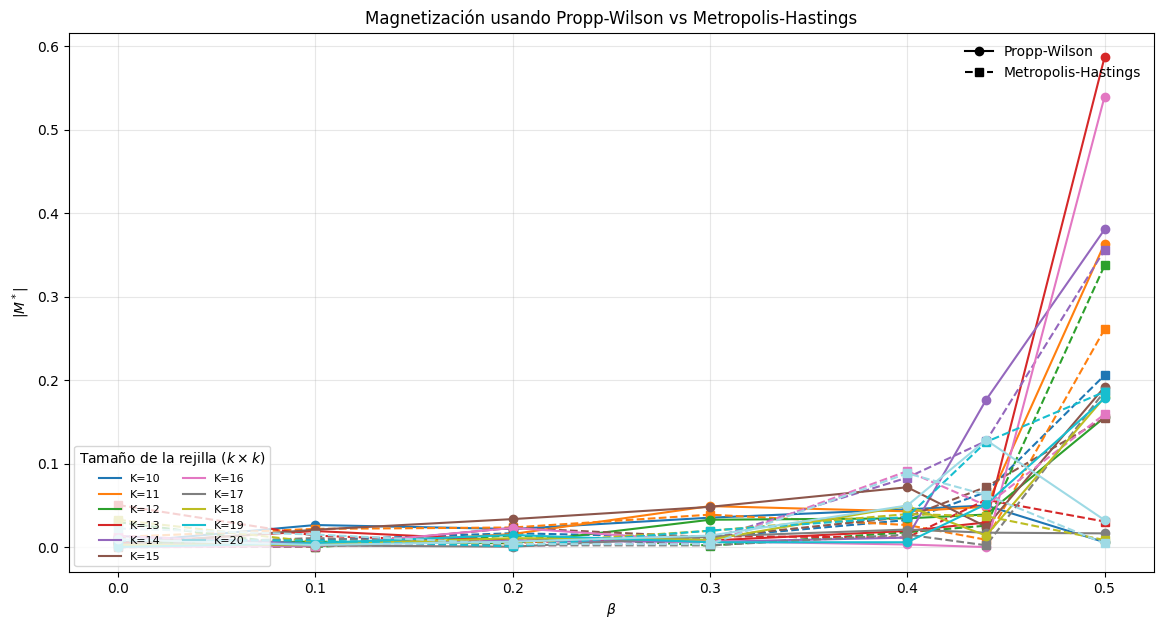

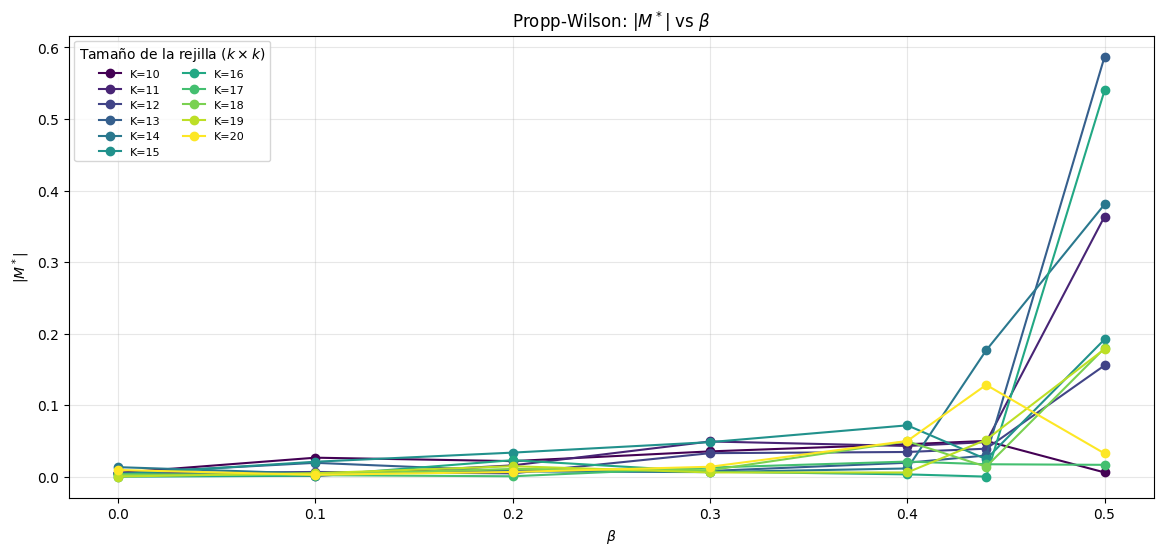

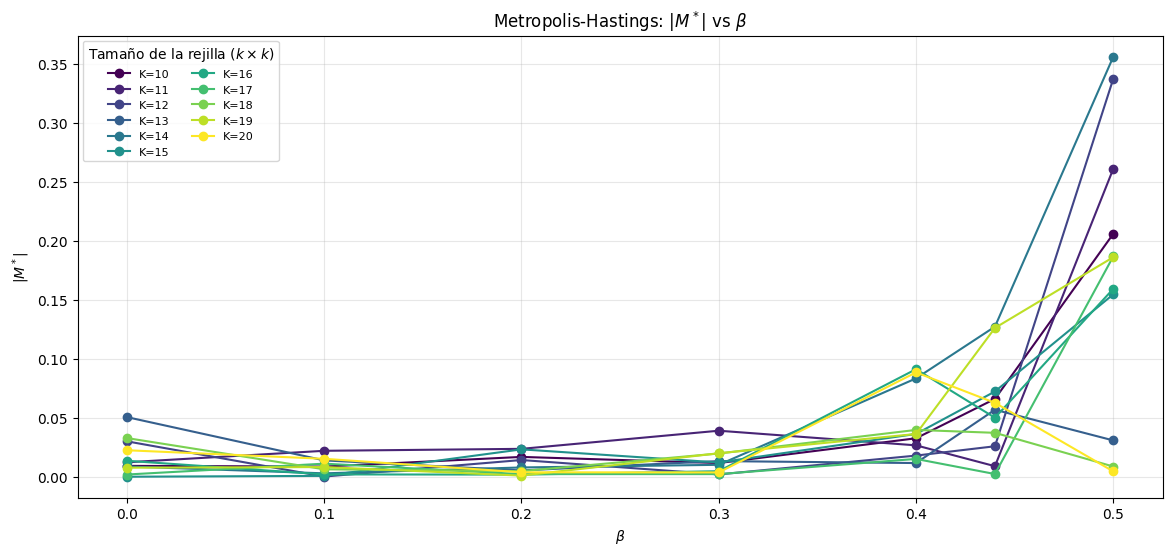

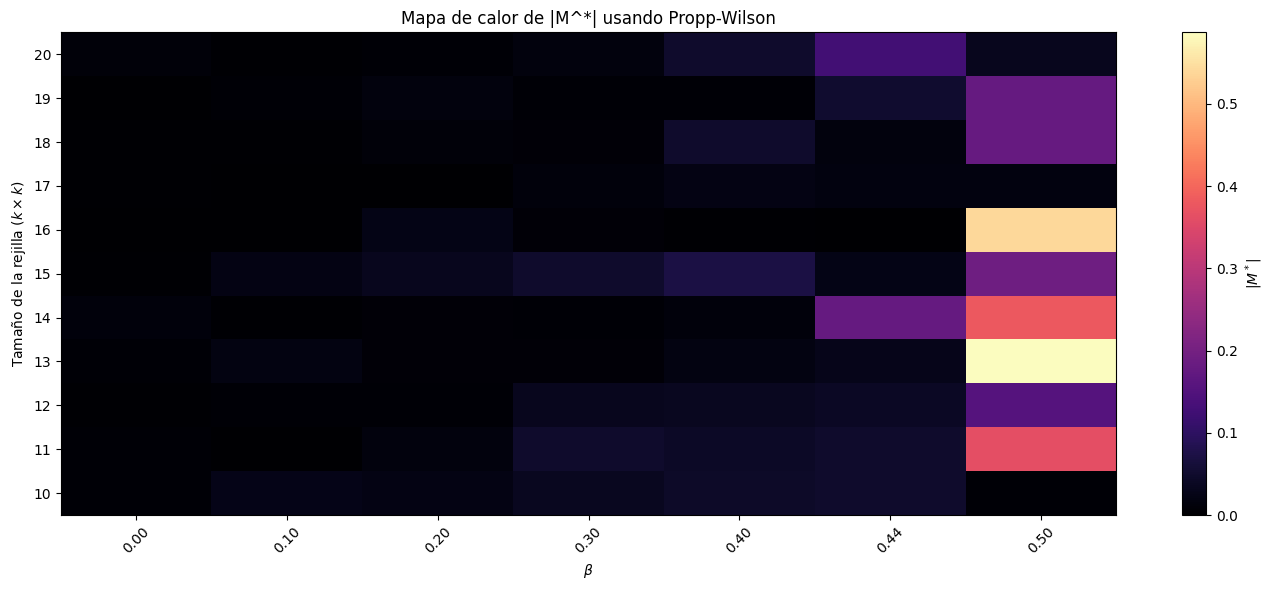

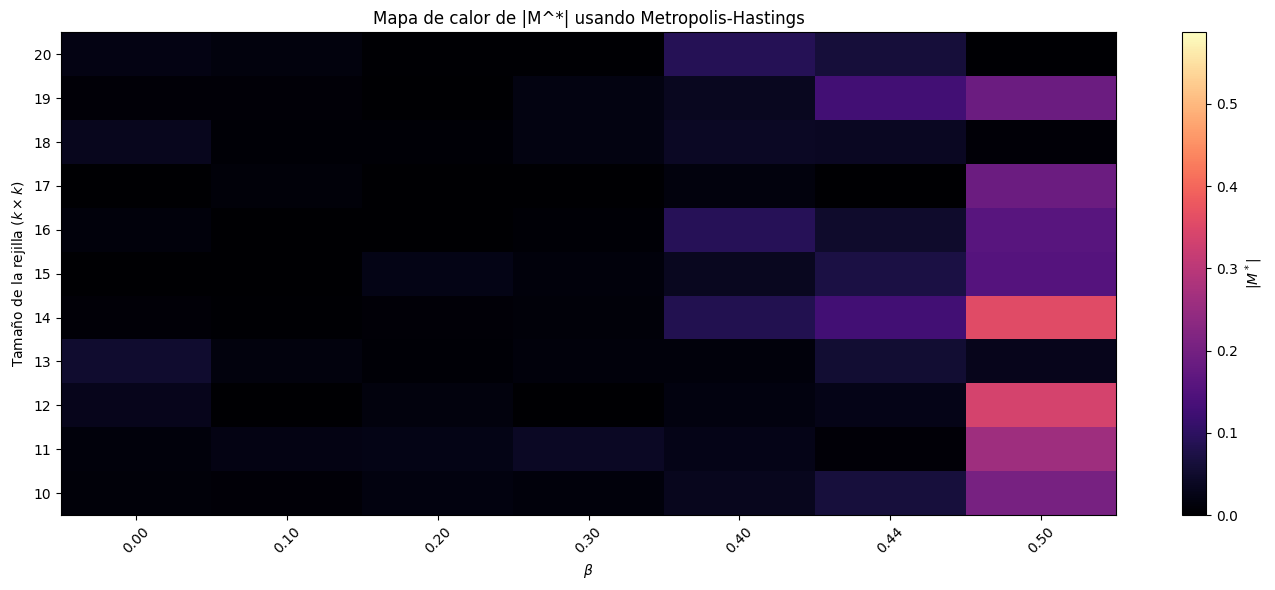

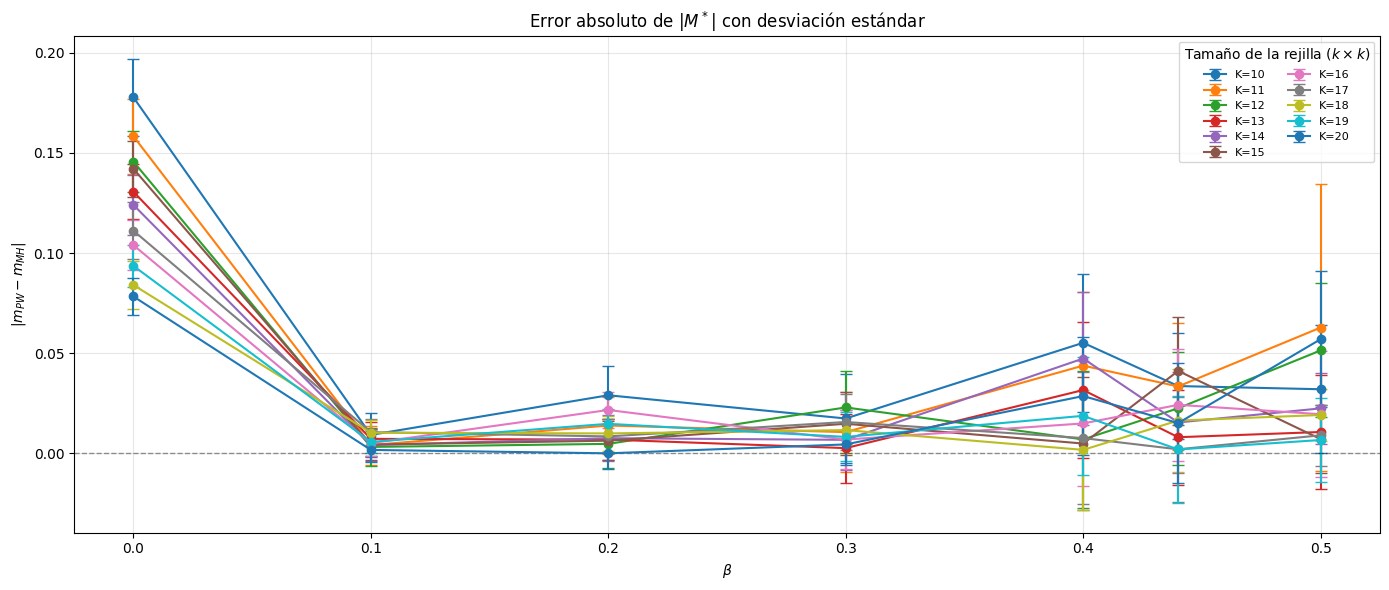

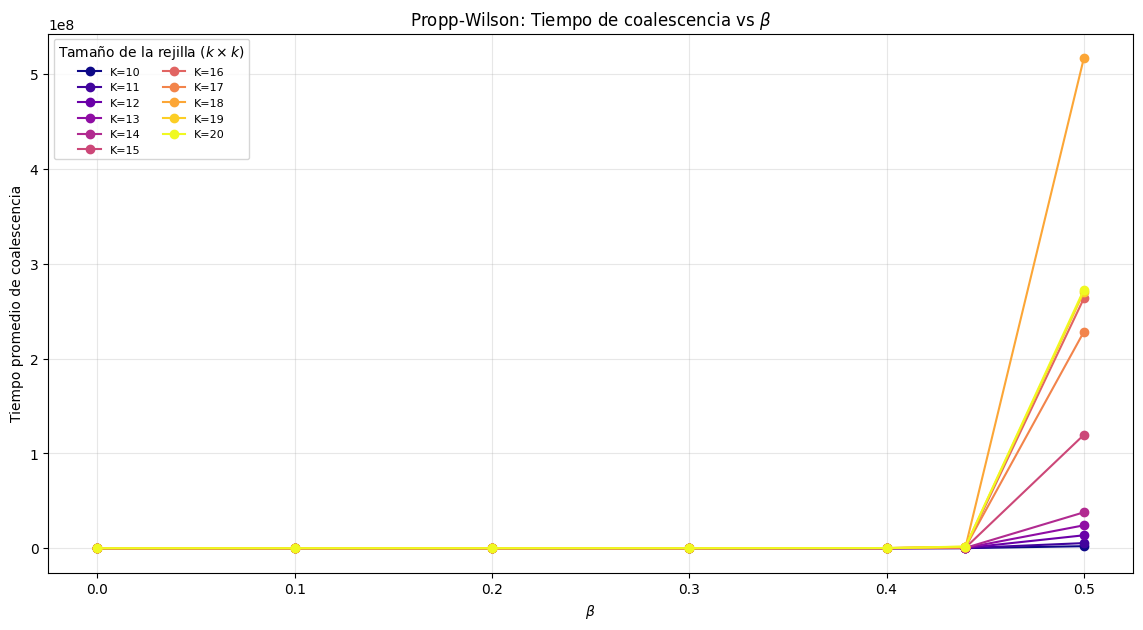

,k,beta,magnetization,coupling_time
0,10,0.00,0.00540,7.475200e+02
1,10,0.10,-0.02660,1.116160e+03
2,10,0.20,0.02180,2.048000e+03
3,10,0.30,-0.03540,4.812800e+03
4,10,0.40,0.04540,2.396160e+04
...,...,...,...,...
72,20,0.20,0.00665,9.830400e+03
73,20,0.30,-0.01390,2.883584e+04
74,20,0.40,-0.04995,2.011955e+05
75,20,0.44,-0.12835,1.758986e+06


In [49]:
pw_summary = summarize_results("pw")
mcmc_summary = summarize_results("mcmc")

plot_combined(pw_summary, mcmc_summary)
plot_method(pw_summary, r"Propp-Wilson: $|M^*|$ vs $\beta$")
plot_method(mcmc_summary, r"Metropolis-Hastings: $|M^*|$ vs $\beta$")
plot_heatmaps_with_shared_scale(pw_summary, mcmc_summary)
plot_delta_errorbars(pw_summary, mcmc_summary)
df_ct = plot_coupling_time(pw_summary)
df_ct

In [38]:
pivot_table = df_ct.dropna(subset=["coupling_time"]).pivot(index="k", columns="beta", values="coupling_time")
pivot_table

beta,0.00,0.10,0.20,0.30,0.40,0.44,0.50
k,,,,,,,
10,747.52,1116.16,2048.00,4812.80,23961.60,113459.20,2136473.6
11,993.28,1382.40,2396.16,6656.00,34897.92,149094.40,5400166.4
12,1116.16,1761.28,3031.04,7741.44,43581.44,224624.64,13631488.0
13,1402.88,1976.32,3993.60,9297.92,63733.76,304087.04,24143462.4
14,1689.60,2375.68,4239.36,11550.72,71270.40,413532.16,37853593.6
15,2129.92,2949.12,5017.60,13271.04,87162.88,575733.76,119537664.0
16,2150.40,3543.04,6184.96,16875.52,106168.32,774307.84,263402291.2
17,2396.16,4157.44,7495.68,17694.72,110428.16,1087242.24,228170137.6
18,2949.12,4648.96,8355.84,20561.92,154664.96,1193410.56,516738252.8
